In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

2023-01-27 21:33:40.756052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 21:33:40.982725: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-27 21:33:40.993510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-27 21:33:40.993541: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
train_df = pd.read_csv('train_1Dy.csv',nrows=1000)
test_df = pd.read_csv('test_1Dy.csv',nrows=500)

In [3]:
X_train = train_df.drop(columns=['y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-midplane','cotBeta']).values

y_train = train_df['y-midplane'].values
y_test = test_df['y-midplane'].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [5]:
maxval = 1e9
minval = 1e-9

pi = 3.14159265359
sqrtPiOn2 = 1.25331413732
sqrt2 = 1.41421356237

def double_crystalball_norm(mu, sigma, alphaL, nL, alphaR, nR):
    
    LN_top = tf.math.exp(-0.5*alphaL*alphaL)*nL
    LN_bottom = alphaL*(nL-1.0)

    RN_top = tf.math.exp(-0.5*alphaR*alphaR)*nR
    RN_bottom = alphaR*(nR-1.0)

    CN = sqrtPiOn2 * (tf.math.erf(alphaL/sqrt2) + tf.math.erf(alphaR/sqrt2))

    den = (1.0*LN_top/LN_bottom + 1.0*RN_top/RN_bottom + CN) * sigma
    
    return 1.0/den


In [6]:
def dscb_jennet(y, p):
       
    mu     = tf.gather(params=p, indices=[0], axis=1)
    sigma  = 0.01 + tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
    alphaR = 0.01 + tf.math.softplus(tf.gather(params=p, indices=[2], axis=1))
    nR     = 1.01 + tf.math.softplus(tf.gather(params=p, indices=[3], axis=1))
    alphaL = 0.01 + tf.math.softplus(tf.gather(params=p, indices=[4], axis=1))
    nL     = 1.01 + tf.math.softplus(tf.gather(params=p, indices=[5], axis=1))
    
    t = 1.0*(y-mu)/sigma
    
    norm = double_crystalball_norm(mu, sigma, alphaL, nL, alphaR, nR) 
        
    def fLeft(): 
        # Replace low tail
        factL = 1 - 1.0*alphaL*alphaL/nL - 1.0*t*alphaL/nL
        termLeft = tf.math.exp(-0.5*alphaL*alphaL) * tf.math.pow(factL, -1.0*nL)
        return norm*termLeft
                         
    def fRight(): 
        # Replace high tail
        factR = 1 - 1.0*alphaR*alphaR/nR + 1.0*t*alphaR/nR
        termRight = tf.math.exp(-0.5*alphaR*alphaR) * tf.math.pow(factR, -1.0*nR)
        return norm*termRight

    def fCenter(): 
        return norm*tf.math.exp(-0.5*t*t)
    
    
    likelihood = tf.case([(tf.less(t,-1*alphaL), fLeft), (tf.greater(t,alphaR), fRight), (tf.less(t,alphaR) and tf.greater(t,-1*alphaL),fCenter)])           
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    
    NLL = -1.0*tf.math.log(likelihood)  
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(6, name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=dscb_jennet)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                896       
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 dense2 (Dense)              (None, 6)                 390       
                                                                 
Total params: 1,286
Trainable params: 1,286
Non-trainable params: 0
_________________________________________________________________


2023-01-27 21:33:43.464398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-27 21:33:43.464452: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-27 21:33:43.464488: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jennetd): /proc/driver/nvidia/version does not exist
2023-01-27 21:33:43.464910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
es = EarlyStopping(patience=10,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=100, 
                    batch_size=1,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/100


2023-01-27 21:33:45.947201: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'dscb_jennet/case/cond/output/_25'


800/800 [==============================] - 6s 4ms/step - loss: 3.7042 - val_loss: 3.1948
Epoch 2/100
800/800 [==============================] - 3s 3ms/step - loss: 3.1692 - val_loss: 2.9558
Epoch 3/100
800/800 [==============================] - 2s 3ms/step - loss: 2.9712 - val_loss: 2.8951
Epoch 4/100
800/800 [==============================] - 3s 4ms/step - loss: 2.8537 - val_loss: 2.8593
Epoch 5/100
800/800 [==============================] - 2s 3ms/step - loss: 2.7616 - val_loss: 2.7951
Epoch 6/100
800/800 [==============================] - 3s 3ms/step - loss: 2.6856 - val_loss: 2.7688
Epoch 7/100
800/800 [==============================] - 2s 3ms/step - loss: 2.6272 - val_loss: 2.6797
Epoch 8/100
800/800 [==============================] - 3s 3ms/step - loss: 2.5557 - val_loss: 2.6438
Epoch 9/100
800/800 [==============================] - 2s 3ms/step - loss: 2.4921 - val_loss: 2.6041
Epoch 10/100
800/800 [==============================] - 2s 3ms/step - loss: 2.4640 - val_loss: 2.5540
E

/tmp/ipykernel_59805/4052347745.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


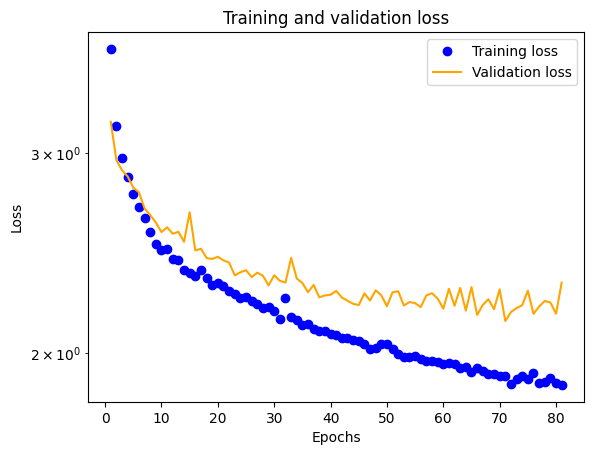

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()

In [10]:
#model.save('models_1Dy/gausstest.keras')

In [11]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma','alphaR','alphaL','nR','nL'])
df['sigma'] = 0.01 + tf.math.softplus(df['sigma'])
df['alphaR'] = 0.01 + tf.math.softplus(df['alphaR'])
df['alphaL'] = 0.01 + tf.math.softplus(df['alphaL'])
df['nR'] = 1.01 + tf.math.softplus(df['nR'])
df['nL'] = 1.01 + tf.math.softplus(df['nL'])
df['ytrue'] = y_test
df.to_csv("test_1DyDCSB.csv",header=False,index=False)

16/16 [==============================] - 0s 2ms/step


In [12]:
residuals = y_test - df['mu']

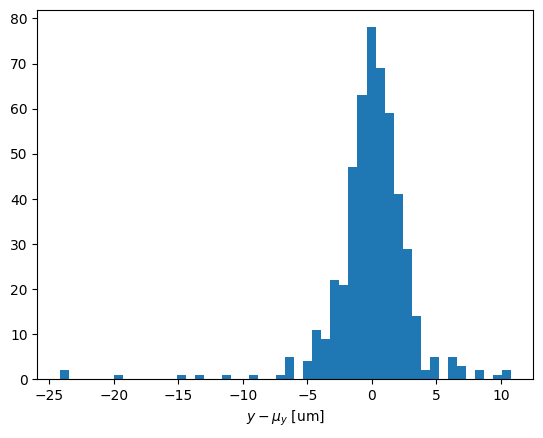

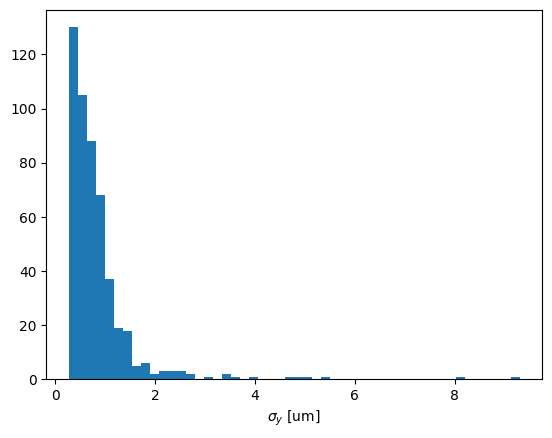

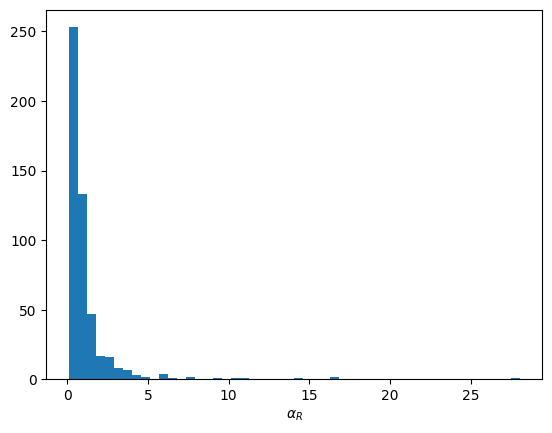

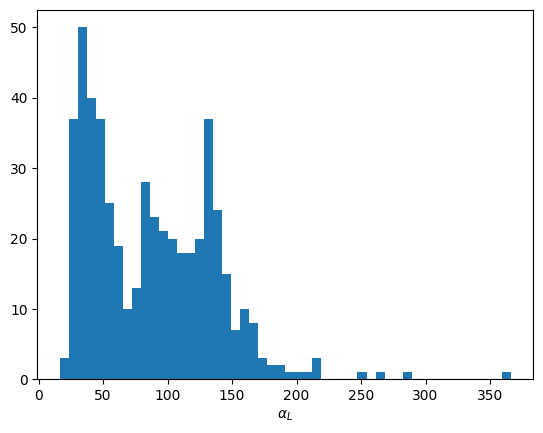

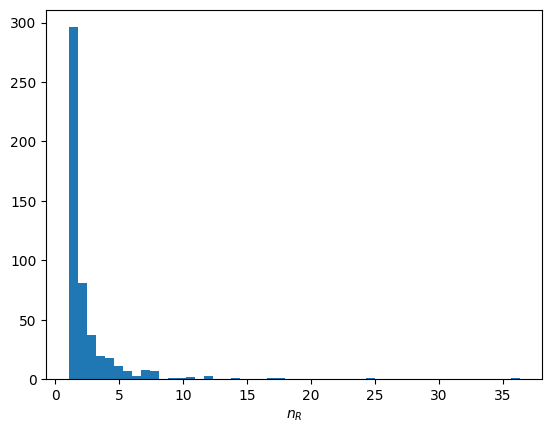

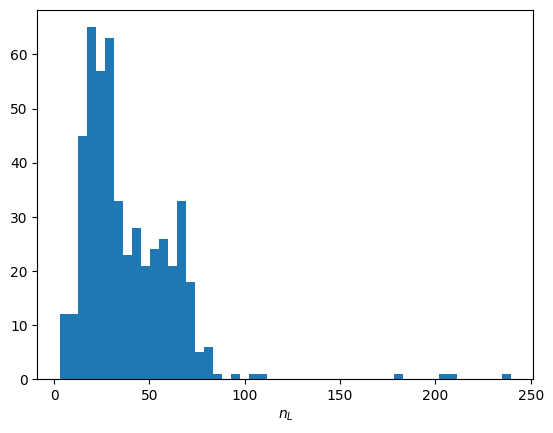

In [13]:
plt.hist(residuals,bins=50)
plt.xlabel(r'$y-\mu_y$ [um]')
plt.show()

plt.hist(df['sigma'],bins=50);
plt.xlabel(r'$\sigma_y$ [um]')
plt.show()

plt.hist(df['alphaR'],bins=50);
plt.xlabel(r'$\alpha_R$')
plt.show()

plt.hist(df['alphaL'],bins=50);
plt.xlabel(r'$\alpha_L$')
plt.show()

plt.hist(df['nR'],bins=50);
plt.xlabel(r'$n_R$')
plt.show()

plt.hist(df['nL'],bins=50);
plt.xlabel(r'$n_L$')
plt.show()

Text(0, 0.5, 'Predicted $y$ [um]')

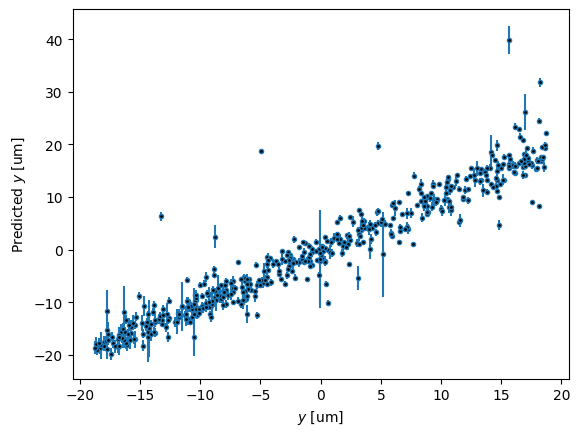

In [14]:
plt.errorbar(x=y_test,y=df['mu'],yerr=df['sigma'],linestyle='',marker='.',markerfacecolor='black')
plt.xlabel(r'$y$ [um]')
plt.ylabel(r'Predicted $y$ [um]')

Text(0, 0.5, '$\\sigma_y$ [um]')

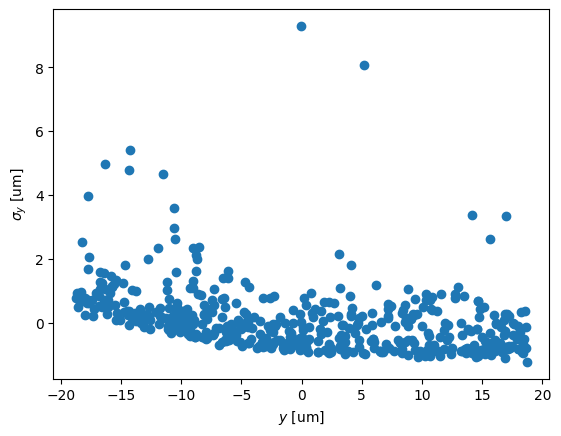

In [15]:
plt.scatter(y_test,p_test[:,1])
plt.xlabel(r'$y$ [um]')
plt.ylabel(r'$\sigma_y$ [um]')

In [16]:
pulls = residuals/df['sigma']

Text(0.5, 0, 'pull')

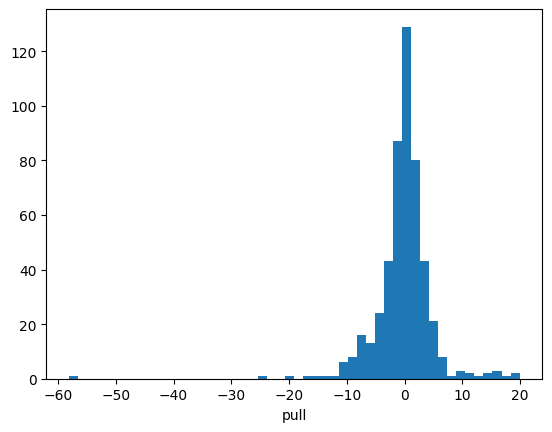

In [17]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [18]:
print(np.mean(pulls),np.std(pulls))

-0.16362463073806074 5.185348167264342
